In [21]:
import os
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit

from preproccesor import WeatherDataPreprocessor

warnings.filterwarnings(action='ignore', category=UserWarning)

# 시각화에 사용할 팔레트
plt.style.available

sns.color_palette("pastel")
sns.set(palette='pastel')

c:\Users\smlee\Desktop\python\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. valid 확인

In [2]:
df_train = pd.read_csv('data/weather_data_imputed2.csv')
df_train

,tm,branch_id,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,...,date,year,month,day,hour,quarter,day_of_week,season,is_weekend,hour_group
0,2021-01-01 01:00:00,A,-10.1,78.3,0.5,0.0,0.0,68.2,0.0,-8.2,...,2021-01-01,2021,1,1,1,1,4,Winter,Weekday,0
1,2021-01-01 02:00:00,A,-10.2,71.9,0.6,0.0,0.0,69.9,0.0,-8.6,...,2021-01-01,2021,1,1,2,1,4,Winter,Weekday,0
2,2021-01-01 03:00:00,A,-10.0,360.0,0.0,0.0,0.0,69.2,0.0,-8.8,...,2021-01-01,2021,1,1,3,1,4,Winter,Weekday,1
3,2021-01-01 04:00:00,A,-9.3,155.9,0.5,0.0,0.0,65.0,0.0,-8.9,...,2021-01-01,2021,1,1,4,1,4,Winter,Weekday,1
4,2021-01-01 05:00:00,A,-9.0,74.3,1.9,0.0,0.0,63.5,0.0,-9.2,...,2021-01-01,2021,1,1,5,1,4,Winter,Weekday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499296,2023-12-31 19:00:00,S,3.2,233.5,0.4,2.5,0.0,91.5,0.0,2.8,...,2023-12-31,2023,12,31,19,4,6,Winter,Weekend,6
499297,2023-12-31 20:00:00,S,2.9,227.4,0.1,2.5,0.0,92.1,0.0,2.7,...,2023-12-31,2023,12,31,20,4,6,Winter,Weekend,6
499298,2023-12-31 21:00:00,S,2.1,360.0,0.0,2.5,0.0,93.3,0.0,1.4,...,2023-12-31,2023,12,31,21,4,6,Winter,Weekend,7
499299,2023-12-31 22:00:00,S,2.2,30.0,1.4,2.5,0.0,95.5,0.0,1.3,...,2023-12-31,2023,12,31,22,4,6,Winter,Weekend,7


In [4]:
preprocessor = WeatherDataPreprocessor()

cluster_results = preprocessor.preprocess_data(df_train, is_test=False)
cluster0_df = cluster_results.get('cluster0')
cluster1_df = cluster_results.get('cluster1')
cluster2_summer_df = cluster_results.get('cluster2_summer')
cluster2_non_summer_df = cluster_results.get('cluster2_non_summer')
cluster3_df = cluster_results.get('cluster3')

데이터 전처리 시작...
cluster2_summer 전처리 중...
cluster2_non_summer 전처리 중...
cluster1 전처리 중...
cluster0 전처리 중...
cluster3 전처리 중...
클러스터별 데이터 전처리 완료!


In [ ]:
# 데이터 준비
df = cluster0_df.copy()
df = df.sort_values(["tm", "branch_id"]).reset_index(drop=True)

# 타겟 지정
target_col = "heat_demand_log"
y = df[target_col]

# object 컬럼만 추출해서 원핫 인코딩
object_cols = df.select_dtypes(include="object").columns.tolist()

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(df[object_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(object_cols))

#수치형 변수 추출
exclude_cols = object_cols + ["tm", target_col, "heat_demand"]
numeric_df = df.drop(columns=exclude_cols)

# 최종 피처 구성
X = pd.concat([numeric_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# TimeSeriesSplit으로 시계열 학습 및 검증
tscv = TimeSeriesSplit(n_splits=3)

rmse_list = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_val_true = np.expm1(y_val)
    y_pred_true = np.expm1(y_pred)
    rmse = mean_squared_error(y_val_true, y_pred_true)
    rmse_list.append(rmse)
    print(f"[Fold {fold}] RMSE: {rmse:.4f}")


print(f"평균 RMSE: {np.mean(rmse_list):.4f}")


[Fold 1] RMSE: 1375.6311
[Fold 2] RMSE: 214.2879
[Fold 3] RMSE: 130.7653


## 마지막 fold 시각화

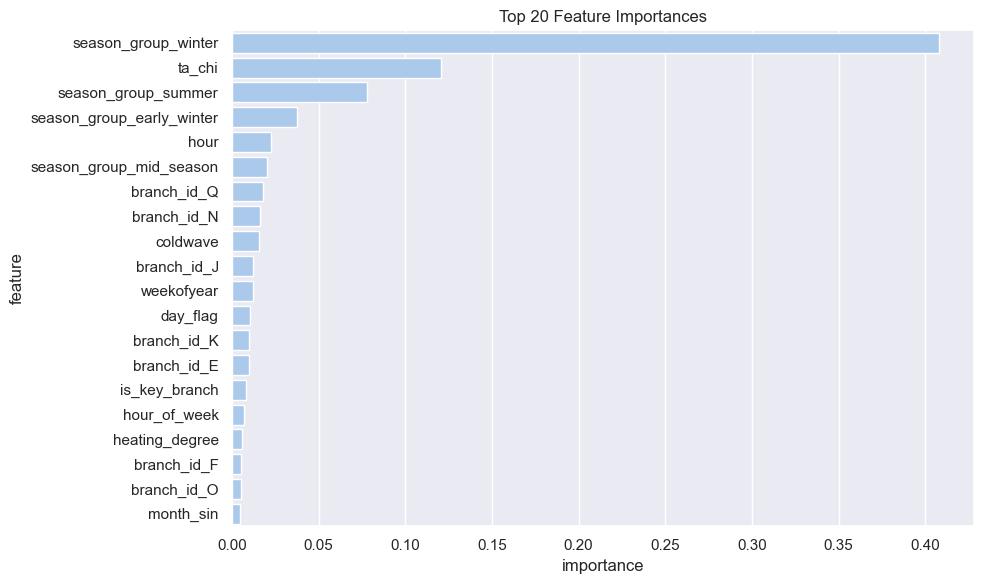

In [ ]:
# feature importance
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df.head(20))  # 상위 20개
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


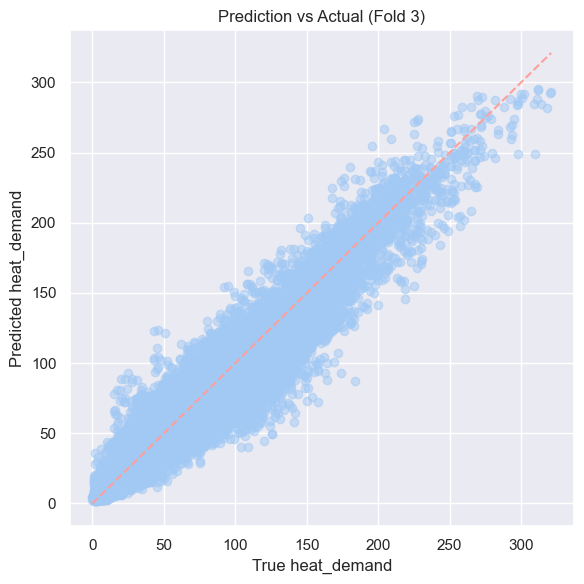

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_pred_true, alpha=0.5)
plt.plot([y_val_true.min(), y_val_true.max()], [y_val_true.min(), y_val_true.max()], 'r--')
plt.xlabel("True heat_demand")
plt.ylabel("Predicted heat_demand")
plt.title("Prediction vs Actual (Fold 3)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 파라미터 튜닝

In [ ]:
# 데이터 전처리
df = cluster0_df.copy()
df = df.sort_values(["tm", "branch_id"]).reset_index(drop=True)

target_col = "heat_demand_log"
y = df[target_col]

# object 컬럼 원핫 인코딩
object_cols = df.select_dtypes(include="object").columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(df[object_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(object_cols))

# 나머지 수치형 변수
exclude_cols = object_cols + ["tm", target_col, "heat_demand"]
numeric_df = df.drop(columns=exclude_cols)

# 최종 feature
X = pd.concat([numeric_df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "n_jobs": -1
    }

    # 시계열 CV로 RMSE 평가
    tscv = TimeSeriesSplit(n_splits=3)
    rmse_list = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)

        # 로그 → 원래 단위
        y_val_true = np.expm1(y_val)
        y_pred_true = np.expm1(y_pred)

        rmse = mean_squared_error(y_val_true, y_pred_true)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Optuna 튜닝 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)  # timeout=600초, n_trials=50개 등 조절 가능

# 최적 하이퍼파라미터 출력
print("Best trial:")
print(study.best_trial)


[I 2025-06-14 19:54:17,258] A new study created in memory with name: no-name-8acd918b-eb26-4019-8c33-fab6aad252a8


# 3. 최종 예측

In [ ]:
# test 데이터 준비 및 전처리
df_test = pd.read_csv('data/weather_data_test.csv')  # test 데이터 불러오기

# 같은 WeatherDataPreprocessor를 써서 클러스터별로 분리한다고 가정
cluster_results_test = preprocessor.preprocess_data(df_test, is_test=True)
cluster0_test_df = cluster_results_test.get('cluster0')

# test 데이터 정렬 및 인덱스 재설정
df_test_cluster0 = cluster0_test_df.sort_values(["tm", "branch_id"]).reset_index(drop=True)

# test 데이터에서 object 컬럼 추출
object_cols_test = df_test_cluster0.select_dtypes(include="object").columns.tolist()

# train 때 사용한 encoder를 그대로 쓰기 때문에 여기서는 transform만 한다
encoded_array_test = encoder.transform(df_test_cluster0[object_cols_test])
encoded_df_test = pd.DataFrame(encoded_array_test, columns=encoder.get_feature_names_out(object_cols_test))

# 수치형 변수 추출
exclude_cols_test = object_cols_test + ["tm", "heat_demand"]  # test에는 타겟 없음
numeric_df_test = df_test_cluster0.drop(columns=exclude_cols_test)

# 최종 test 피처 구성
X_test = pd.concat([numeric_df_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)


# train 데이터 전체로 최종 모델 학습
model_final = XGBRegressor(random_state=42, n_jobs=-1)
model_final.fit(X, y)


# test 데이터 예측
y_test_pred_log = model_final.predict(X_test)

# 로그 역변환 (원 단위 예측값)
y_test_pred = np.expm1(y_test_pred_log)


# 결과 확인 (예: test 데이터에 예측 칼럼 추가)
df_test_cluster0['heat_demand_pred'] = y_test_pred

print(df_test_cluster0[['tm', 'branch_id', 'heat_demand_pred']].head())
